In [1]:
import xarray as xr
import numpy as np
import os
import glob

from matplotlib import pyplot as plt

In [2]:
def printSpan(ds):
    xc0, xc1 = ds.X.values[[0, -1]]
    yc0, yc1 = ds.Y.values[[0, -1]]
    print( f"Span of Tile {ds.tile_number}",
           f"\nLon: [{xc0:0.3f}, {xc1:0.3f}]N,",
           f"\nLat: [{yc0:0.3f}, {yc1:0.3f}]E,",
         )
    return None

In [3]:
tIDs = np.array( sorted(glob.glob('MNC_ALL/GRID/grid.t*.nc')) )
grids = {}

for tile in tIDs:
    tID = tile.split('.')[1]
    grids[tID] = xr.load_dataset(tile)
    if int(tID[1:])<=12:
        printSpan( grids[tID] ) 

Span of Tile 1 
Lon: [-0.042, 2.542]N, 
Lat: [39.958, 42.958]E,
Span of Tile 2 
Lon: [2.625, 5.208]N, 
Lat: [39.958, 42.958]E,
Span of Tile 3 
Lon: [5.291, 7.875]N, 
Lat: [39.958, 42.958]E,
Span of Tile 4 
Lon: [7.958, 10.541]N, 
Lat: [39.958, 42.958]E,
Span of Tile 5 
Lon: [10.625, 13.208]N, 
Lat: [39.958, 42.958]E,
Span of Tile 6 
Lon: [13.291, 15.874]N, 
Lat: [39.958, 42.958]E,
Span of Tile 7 
Lon: [15.958, 18.541]N, 
Lat: [39.958, 42.958]E,
Span of Tile 8 
Lon: [18.624, 21.207]N, 
Lat: [39.958, 42.958]E,
Span of Tile 9 
Lon: [21.291, 23.874]N, 
Lat: [39.958, 42.958]E,
Span of Tile 10 
Lon: [23.957, 26.541]N, 
Lat: [39.958, 42.958]E,
Span of Tile 11 
Lon: [26.624, 29.207]N, 
Lat: [39.958, 42.958]E,
Span of Tile 12 
Lon: [29.290, 31.874]N, 
Lat: [39.958, 42.958]E,


In [4]:
ds = xr.load_dataset("MNC_ALL/mnc_test_0083/surfDiag.0000000000.t003.nc")
printSpan( ds ) 

Span of Tile 3 
Lon: [5.291, 7.875]N, 
Lat: [39.958, 42.958]E,


In [5]:
# THE WRONG WAY TO LOAD MNC GENERATED TILED FILES
import warnings

from dask.array.core import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)


# Step 2: Open all files using combine='by_coords'
ds_merged = xr.open_mfdataset(tIDs, combine='by_coords')
ds_merged = ds_merged.chunk({'X': 384, 'Y': 444, 'Xp1': 396, 'Yp1': 456})

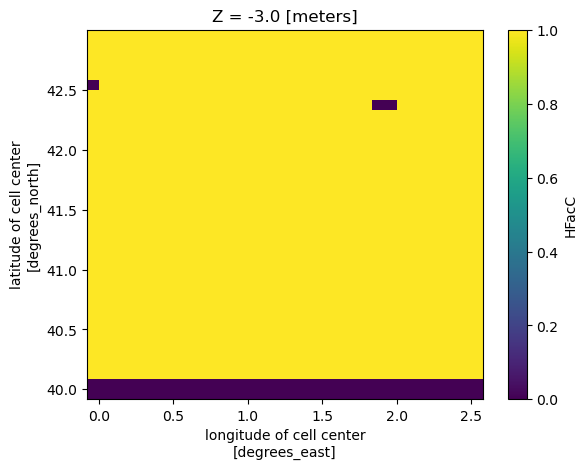

In [6]:
grids['t001'].HFacC.isel(Z=1).plot()

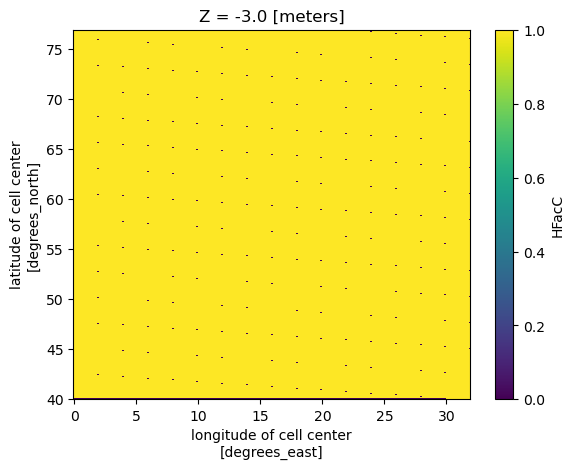

In [7]:
global_grid = xr.load_dataset("MNC_ALL/GRID/grid.glob.nc")
global_grid.HFacC.isel(Z=1).plot()

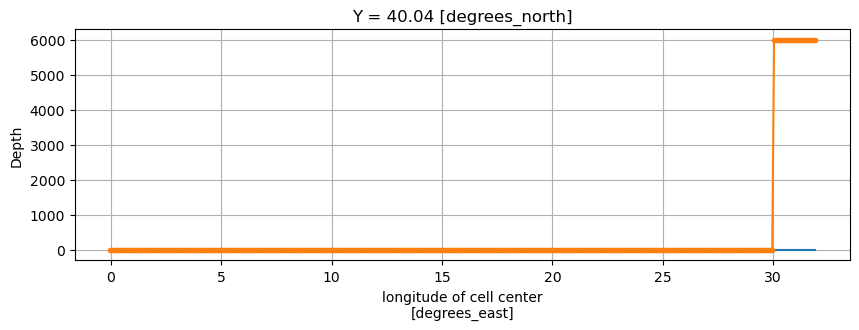

(384,)


In [8]:
plt.figure(figsize=(10,3))
global_grid.Depth.isel(Y=0).plot()
global_grid.Depth.isel(Y=1).plot(marker='.')
plt.grid()
plt.show()
print( global_grid.Depth.isel(Y=0).shape )

Clearly, the bathymetry is incorrect :(, we remade the bathymetry to be:
- a smaller bathtub: `bathy_hd_deep_384x444.bin`
- a truncated bathtub: `bathy_hd_deep_384x444_openSE.bin`

In [9]:
openSE = np.fromfile('/Users/ivana/work/regionalgcm/bcg.hd/input/bathy_hd_deep_384x444_openSE.bin', dtype='>f4').reshape(444,384)

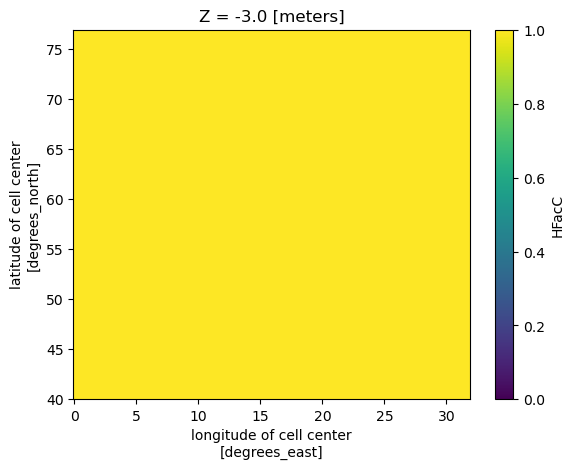

In [11]:
openSE = xr.load_dataset("grid.glob.nc")
openSE.HFacC.isel(Z=1).plot()

Problem solved! Now I need to rerun all the 50 year spinup with these two bathymetry options to see which is the stable solution. I'm currently running only 5 years of wind forcing to see which of the set-ups heads towards a steady state. The key figure to look at the the variance. The variance should peak, then start to stablize at around the 5 year mark. I should look at the results on Sverdrup. 

This notebook was written on my local MacOS. 

In Sverdrup, I have a 50 year spinup with the wrong wind forcing. The wrong wind forcing arrives to some stable mean behavior:

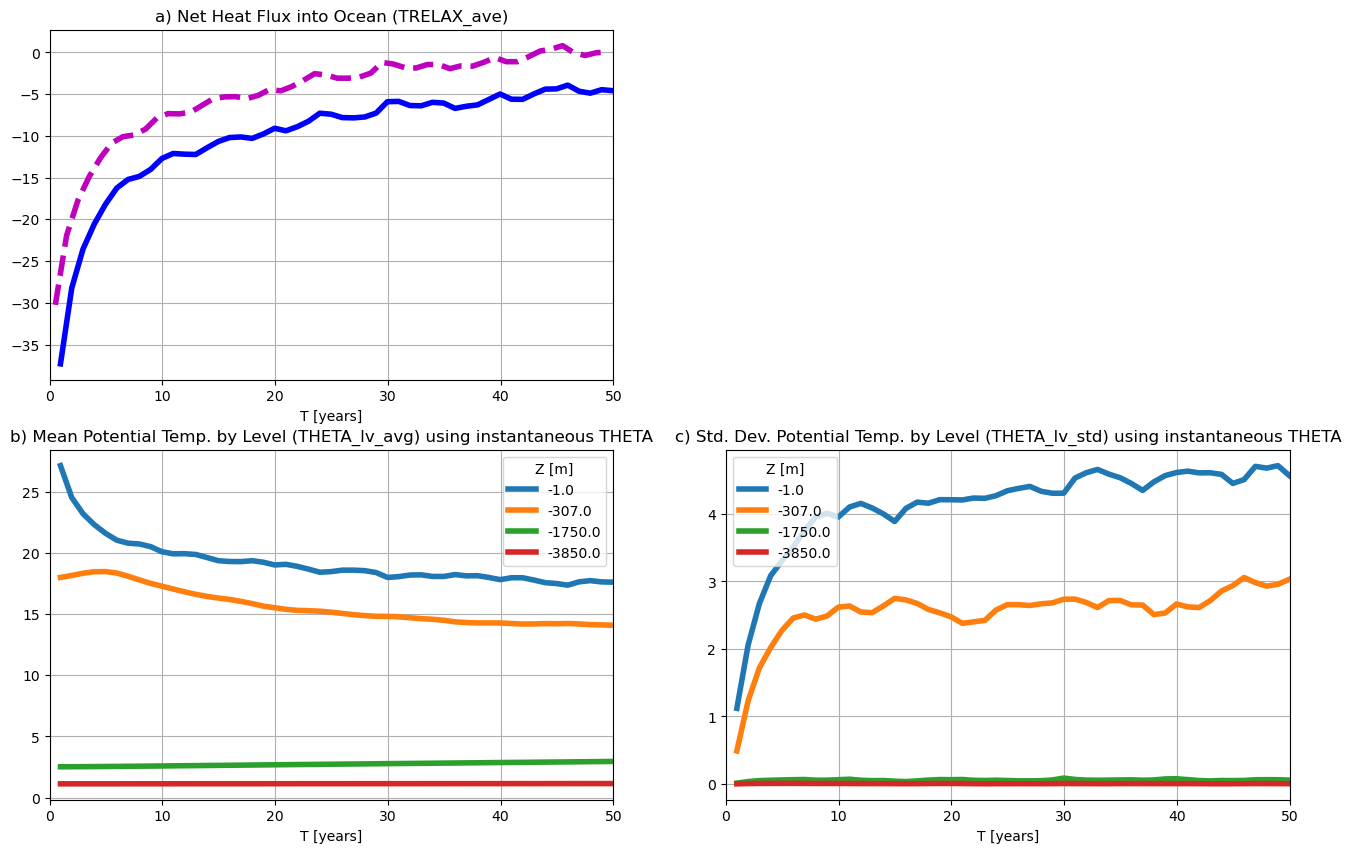

Using the wrong bathymetry, but right wind led to the standard deviation never settling, for obvious reasons. The pockmarked land causes issues:
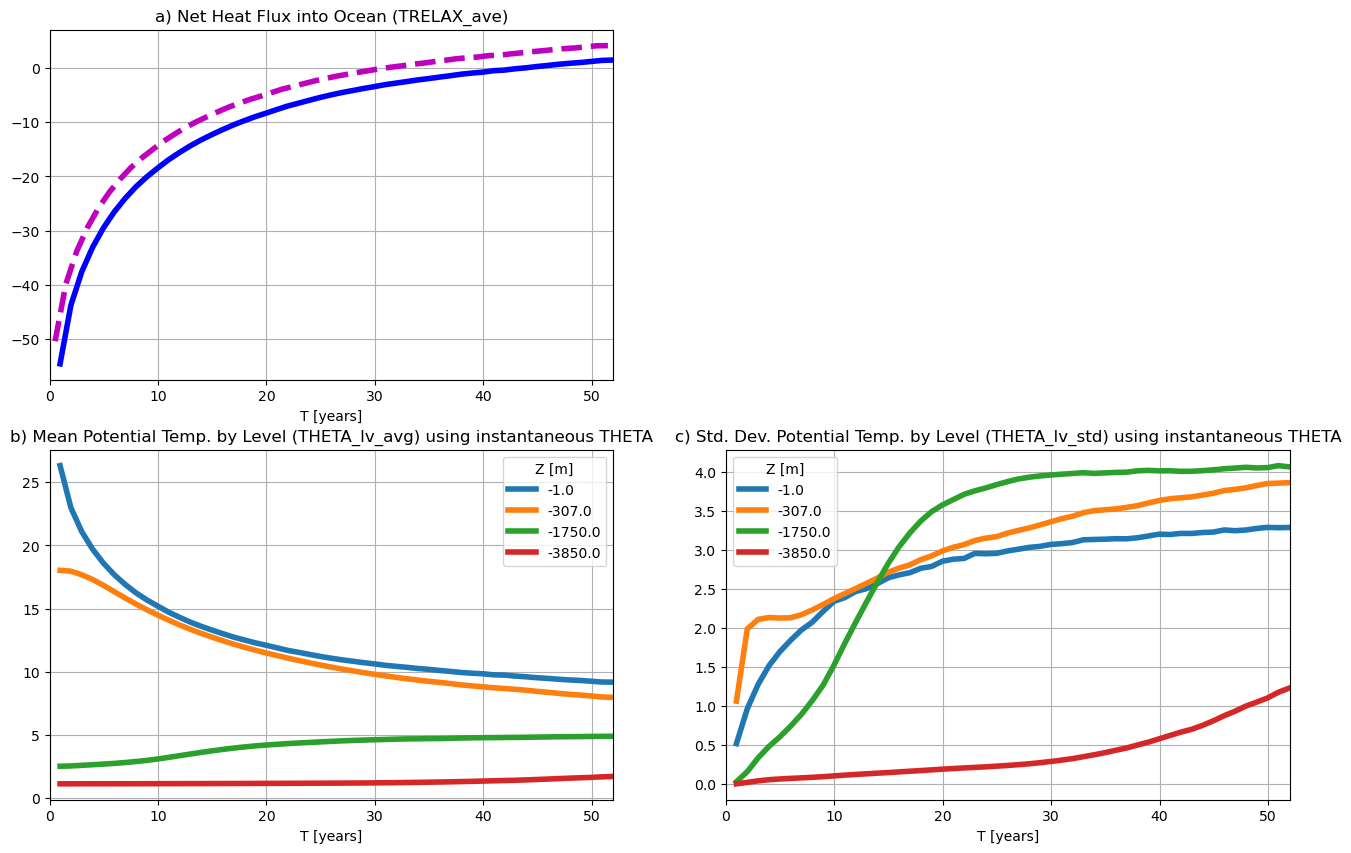

**Liiiike wtf**. So now we use the right wind AND right bathymetry. But have to pick between two bathymetrys. Sverdrup can handle the 5 year runs over the course of 48 hours. Once I know which to choose from, I will test if I can get away with using pickups from the messed up bathymetry spinup in TACC. That's hopefully the path forward so that I can run the 50 year spinup in 48hrs wall time total. The purpose of the spinup is to settle the gyre to a steady state before changing the wind in it. So the spin up for half a century will allow for me to show a figure of the gyre arriving to a steady state. 

_Make sure you have the correct forcings AND bathymetry Ivana!_